c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\rsore\AppData\Local\Temp\ipykernel_23244\305328269.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


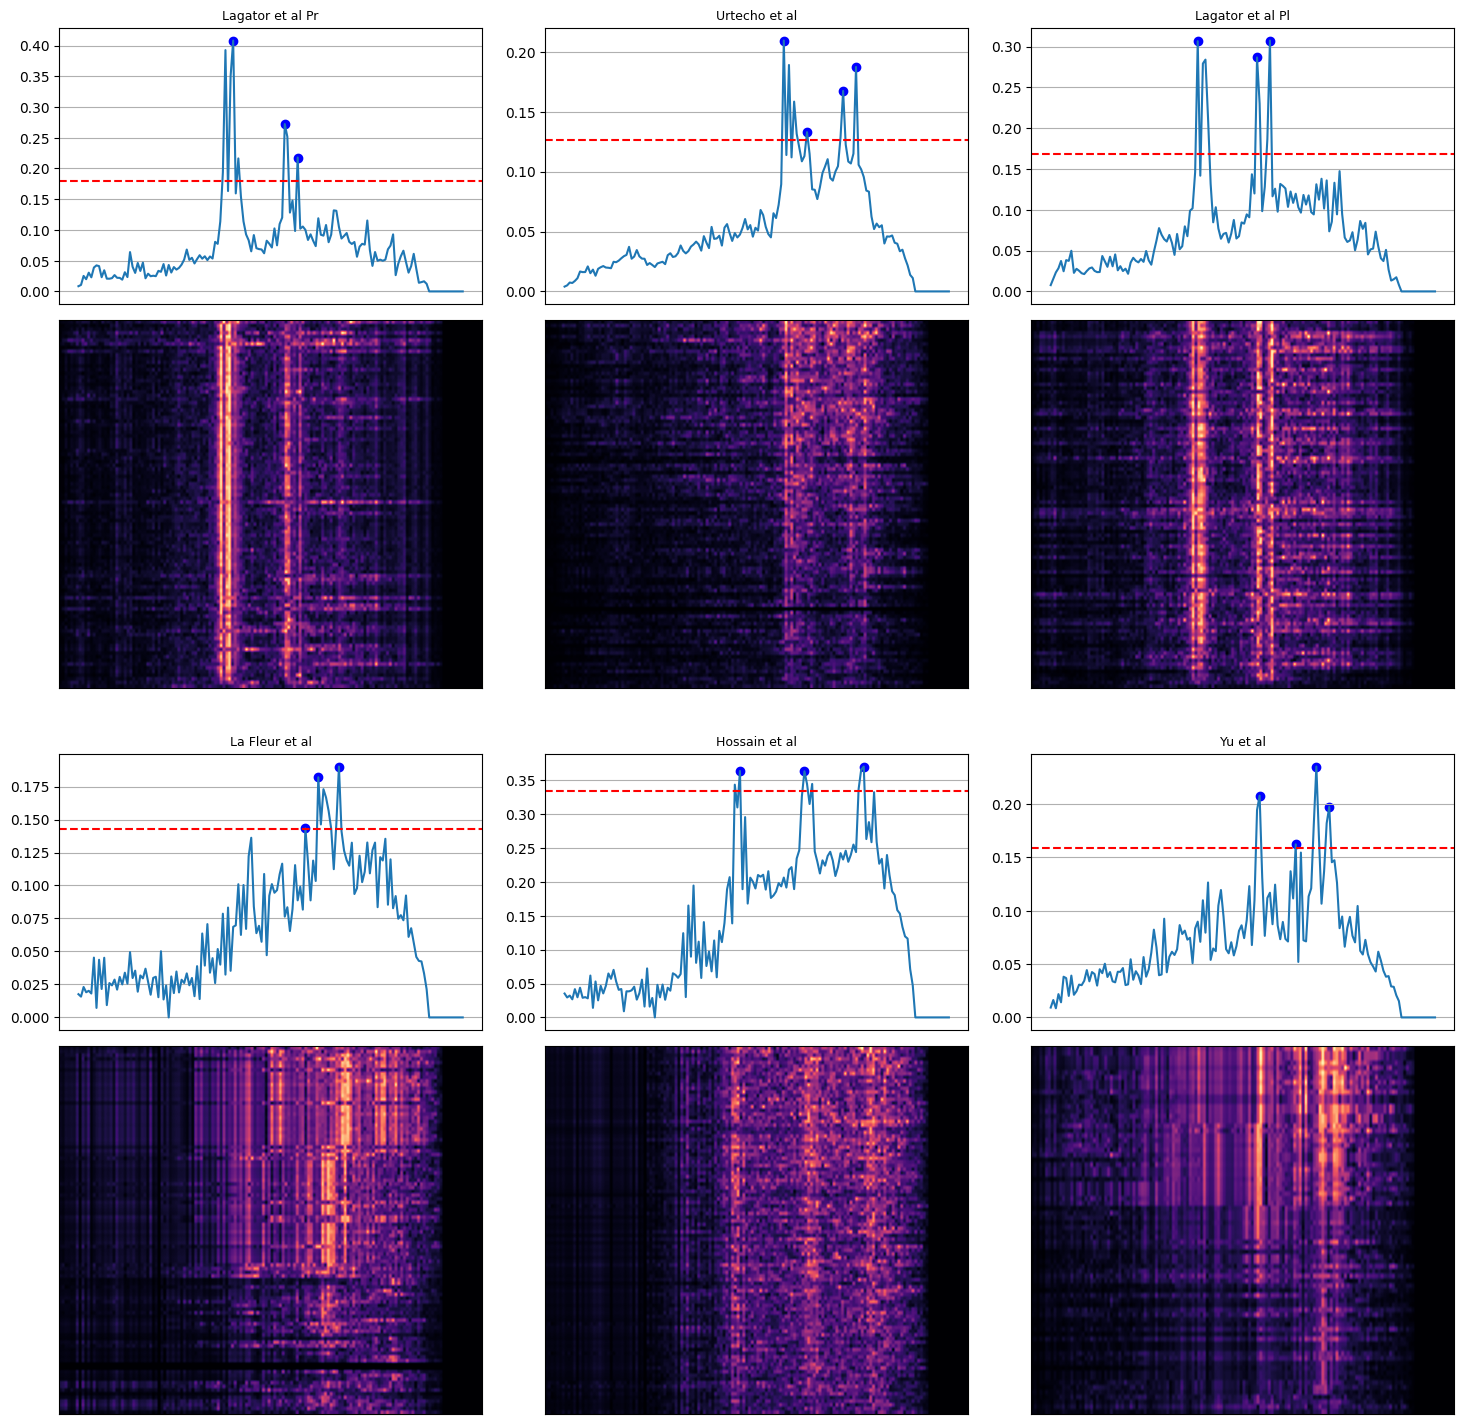

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model  # type: ignore
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

def plot_saliency_map_grid_combined(
    model_filename,
    sequences,
    ax_line=None,
    ax_imshow=None,
    title=None,
    colorbar=False,
):
    model = load_model(model_filename)
    saliency_maps = []
    predictions = []

    for seq in sequences:
        pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
        saliency = np.abs(generate_saliency_map(model, seq)).flatten()
        saliency = np.nan_to_num(saliency)
        saliency = pred * saliency
        predictions.append(pred)
        saliency_maps.append(saliency)

    saliency_maps = [saliency_maps[i] for i in np.argsort(predictions)[::-1]]
    averaged_saliency_maps = np.mean(np.stack(saliency_maps), axis=0)
    q3_iqr = np.percentile(averaged_saliency_maps, 95)
    peaks, _ = find_peaks(averaged_saliency_maps, height=q3_iqr, distance=5)

    if ax_line:
        ax_line.plot(averaged_saliency_maps)
        ax_line.axhline(q3_iqr, color="red", linestyle="--")
        ax_line.scatter(peaks, averaged_saliency_maps[peaks], color="blue")
        ax_line.set_title(f"{title}", fontsize=9)
        ax_line.set_xticks([])
        ax_line.grid(True)

    saliency_matrix = np.vstack(saliency_maps)
    im = ax_imshow.imshow(
        saliency_matrix,
        cmap='magma',
        aspect='auto',
        vmin=saliency_matrix.min(),
        vmax=saliency_matrix.max()
    )
    ax_imshow.set_xticks([])
    ax_imshow.set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax_imshow, fraction=0.046, pad=0.04)
    return im

# -------------------- Main Execution --------------------

# Load data
df = pd.read_csv('Data/LaFleur_supp.csv')[['Promoter Sequence', 'Observed log(TX/Txref)', 'File Name']]

# Preprocess data
df['Promoter Sequence'] = df['Promoter Sequence'].astype(str).apply(lambda x: padded_one_hot_encode(x.zfill(150)))
df['Observed log(TX/Txref)'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())

# Split into train/test (for demonstration – only using test set here)
indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
test_df = df.iloc[test_idx].copy()

# File names to analyze
file_names = ['Lagator et al Pr', 'Urtecho et al', 'Lagator et al Pl', 'La Fleur et al', 'Hossain et al', 'Yu et al']
num_files = len(file_names)

# Create 2x3 grid layout
fig = plt.figure(figsize=(18, 18))
outer_gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)

for idx, file_name in enumerate(file_names):
    subset_df = test_df[test_df['File Name'] == file_name]
    
    # get the top Observed log(TX/Txref) from the subset
    q3_iqr = np.percentile(subset_df['Observed log(TX/Txref)'], 75)
    subset_df = subset_df[subset_df['Observed log(TX/Txref)'] > q3_iqr]
    sequences = subset_df.sample(n=min(100, len(subset_df)), random_state=1)

    # sequences = subset_df.sort_values(by='Observed log(TX/Txref)', ascending=False).head(100)
    data_subset = np.array(sequences['Promoter Sequence'].tolist())

    if len(data_subset) == 0:
        continue

    row, col = divmod(idx, 3)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[row, col], height_ratios=[1.5, 2], hspace=0.05)

    ax_line = fig.add_subplot(inner_gs[0])
    ax_imshow = fig.add_subplot(inner_gs[1])

    plot_saliency_map_grid_combined(
        model_filename='Models/CNN_6_1_2.keras',
        sequences=data_subset,
        ax_line=ax_line,
        ax_imshow=ax_imshow,
        title=file_name,
        colorbar=False
    )

plt.tight_layout()
# plt.savefig('Figures/Figure 3 (peaks).pdf', dpi=300, bbox_inches='tight')
plt.show()


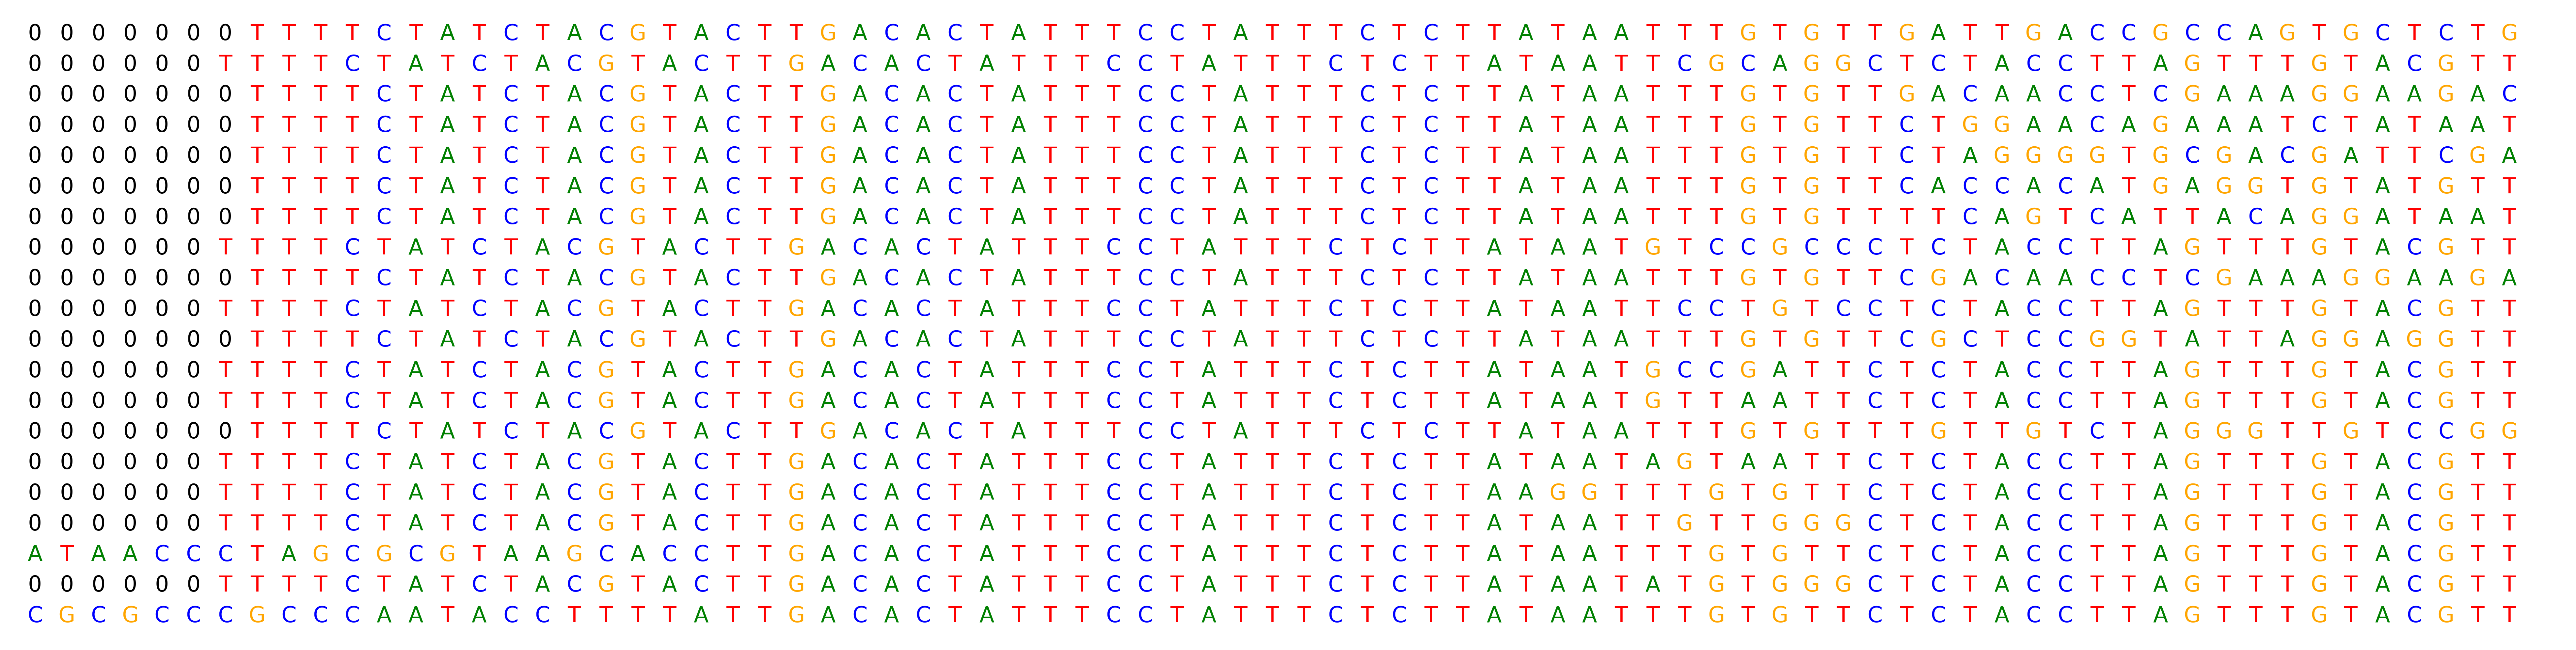

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model  # type: ignore
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

# -------------------- Main Execution --------------------

# Load data
df = pd.read_csv('Data/LaFleur_supp.csv')[['Promoter Sequence', 'Observed log(TX/Txref)', 'File Name']]
df = df[df['File Name'] == 'La Fleur et al']

# drop the 'File Name' column
df = df.drop(columns=['File Name'])

# Preprocess data
df['Promoter Sequence'] = df['Promoter Sequence'].astype(str).apply(lambda x: x.upper())
df['Observed log(TX/Txref)'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())

# Split into train/test (only using test)
indices = np.arange(len(df))
_, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
df = df.iloc[test_idx]

q3_iqr = np.percentile(df['Observed log(TX/Txref)'], 75)
df = df[df['Observed log(TX/Txref)'] > q3_iqr]
df = df.sample(n=min(20, len(df)), random_state=1)

# sort by 'Observed log(TX/Txref)'
df = df.sort_values(by='Observed log(TX/Txref)', ascending=False)

sequences = df['Promoter Sequence'].tolist()
max_length = max(len(seq) for seq in sequences)
sequences = [seq.zfill(max_length) for seq in sequences]


nucleotide_colors = {
    'A': 'green',
    'T': 'red',
    'C': 'blue',
    'G': 'orange'
}

fig, ax = plt.subplots(figsize=(len(sequences[0]), len(sequences)))

# Plot nucleotides
for row_idx, seq in enumerate(sequences):
    for col_idx, base in enumerate(seq):
        ax.text(col_idx, -row_idx, base,
                color=nucleotide_colors.get(base, 'black'),
                fontsize=48, ha='center', va='center')

# Hide axes
ax.set_xlim(-1, len(sequences[0]) + 1)
ax.set_ylim(-len(sequences), 1)
ax.axis('off')

plt.tight_layout()
plt.show()
